# Hohmann Transfer: Earth → Mars (pure NumPy / SciPy implementation)

This notebook computes and visualizes the analytic Hohmann transfer between circular,
coplanar heliocentric orbits (Earth → Mars) without using Poliastro.

It:
- computes analytic Δv₁, Δv₂ and total Δv,
- computes the Hohmann transfer semi-major axis and time-of-flight,
- estimates propellant mass required (rocket equation),
- plots Earth and Mars circular orbits and the Hohmann transfer ellipse,
- saves a small CSV summary to `results/hohmann_summary.csv`.

Units: SI (meters, seconds) internally; printed results shown in km/s and days.

In [2]:
# Imports & constants
import numpy as np
import math
import os
import csv
import matplotlib.pyplot as plt

# Physical constants (SI)
MU_SUN = 1.32712440018e20      # m^3 / s^2 (standard gravitational parameter of Sun)
AU = 1.495978707e11            # 1 astronomical unit in meters
DAY = 86400.0                  # seconds in a day


In [3]:
# Problem parameters (edit these if you want)
r1 = 1.0 * AU                  # Earth orbital radius (m)
r2 = 1.524 * AU                # Mars orbital radius (m)

# Propulsion / mass assumptions (for propellant estimate)
wet_mass_kg = 1000.0           # wet mass (kg)
Isp_s = 320.0                  # specific impulse (s) — adjust for chemical or electric
g0 = 9.80665                   # m/s^2

# Output file
out_dir = "results"
os.makedirs(out_dir, exist_ok=True)
summary_csv = os.path.join(out_dir, "hohmann_summary.csv")


In [4]:
# Analytic Hohmann calculation (vis-viva)
def hohmann_analytic(mu, r1, r2):
    a_trans = 0.5 * (r1 + r2)  # semi-major axis of transfer ellipse (m)
    # circular velocities
    v1 = math.sqrt(mu / r1)
    v2 = math.sqrt(mu / r2)
    # transfer velocities (vis-viva) at r1 and r2
    v_trans_r1 = math.sqrt(mu * (2.0/r1 - 1.0/a_trans))
    v_trans_r2 = math.sqrt(mu * (2.0/r2 - 1.0/a_trans))
    dv1 = abs(v_trans_r1 - v1)
    dv2 = abs(v2 - v_trans_r2)
    dv_total = dv1 + dv2
    # time of flight = half period of transfer ellipse
    tof = math.pi * math.sqrt(a_trans**3 / mu)
    return {
        "a_trans": a_trans,
        "v1": v1, "v2": v2,
        "v_trans_r1": v_trans_r1, "v_trans_r2": v_trans_r2,
        "dv1": dv1, "dv2": dv2, "dv_total": dv_total,
        "tof": tof
    }

res = hohmann_analytic(MU_SUN, r1, r2)

# Print nicely (km/s and days)
dv1_km_s = res["dv1"] / 1000.0
dv2_km_s = res["dv2"] / 1000.0
dv_total_km_s = res["dv_total"] / 1000.0
tof_days = res["tof"] / DAY

print("Hohmann transfer analytic results (Earth -> Mars):")
print(f"  Δv1 = {dv1_km_s:.6f} km/s")
print(f"  Δv2 = {dv2_km_s:.6f} km/s")
print(f"  Total Δv = {dv_total_km_s:.6f} km/s")
print(f"  Transfer semi-major axis a = {res['a_trans'] / AU:.6f} AU")
print(f"  Time of flight (half-period) = {tof_days:.3f} days ({res['tof'] / 3600.0:.2f} hours)")


Hohmann transfer analytic results (Earth -> Mars):
  Δv1 = 2.946055 km/s
  Δv2 = 2.649982 km/s
  Total Δv = 5.596037 km/s
  Transfer semi-major axis a = 1.262000 AU
  Time of flight (half-period) = 258.915 days (6213.96 hours)


In [5]:
# Rocket equation: m_prop = m0 * (1 - exp(-Δv / (Isp * g0)))
dv_total_m_s = res["dv_total"]                # m/s
m0 = wet_mass_kg
m_prop = m0 * (1.0 - math.exp(- dv_total_m_s / (Isp_s * g0)))

print()
print("Propellant estimate (impulsive, single-stage approximation):")
print(f"  Wet mass m0 = {m0:.1f} kg, Isp = {Isp_s:.1f} s")
print(f"  Estimated propellant mass = {m_prop:.3f} kg")



Propellant estimate (impulsive, single-stage approximation):
  Wet mass m0 = 1000.0 kg, Isp = 320.0 s
  Estimated propellant mass = 831.907 kg


In [6]:
# Write a one-row summary CSV (overwrites existing file)
with open(summary_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["run_id","method","target","epoch_note","r1_m","r2_m","dv1_m_s","dv2_m_s","dv_total_m_s","tof_s","wet_mass_kg","Isp_s","propellant_kg"])
    writer.writerow([
        "hohmann_01",
        "Hohmann (analytic)",
        "Mars",
        "circular-coplanar assumption",
        r1, r2,
        res["dv1"], res["dv2"], res["dv_total"],
        res["tof"], m0, Isp_s, m_prop
    ])
print(f"\nSaved summary to {summary_csv}")



Saved summary to results\hohmann_summary.csv


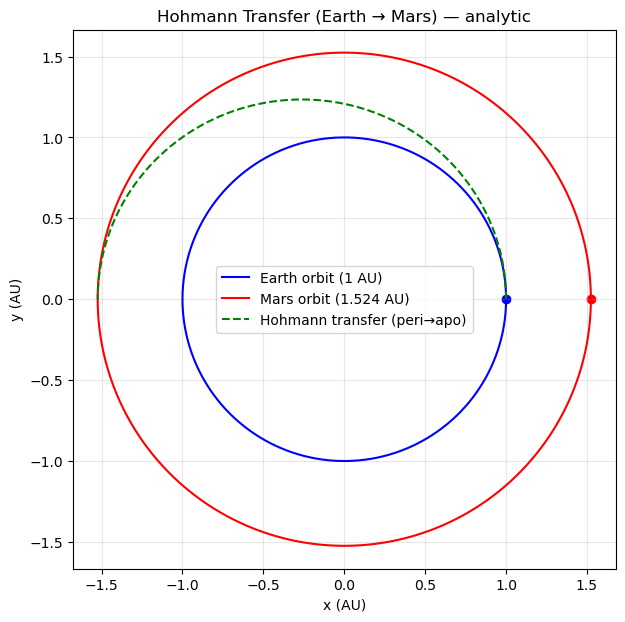

In [7]:
# Plot Earth and Mars circular orbits and Hohmann transfer ellipse (2D, ecliptic plane)
theta = np.linspace(0.0, 2.0*np.pi, 500)

# circular orbits
x_earth = (r1 * np.cos(theta)) / AU
y_earth = (r1 * np.sin(theta)) / AU
x_mars  = (r2 * np.cos(theta)) / AU
y_mars  = (r2 * np.sin(theta)) / AU

# Transfer ellipse: param as true anomaly from 0 -> pi (peri at r1, apogee -> r2)
a = res["a_trans"]
# eccentricity of transfer ellipse (from r1=peri, r2=apo)
e = abs((r2 - r1) / (r2 + r1))
nu = np.linspace(0.0, np.pi, 300)
r_nu = a * (1.0 - e**2) / (1.0 + e * np.cos(nu))
x_trans = (r_nu * np.cos(nu)) / AU
y_trans = (r_nu * np.sin(nu)) / AU

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(x_earth, y_earth, color="blue", label="Earth orbit (1 AU)")
ax.plot(x_mars, y_mars, color="red", label="Mars orbit (1.524 AU)")
ax.plot(x_trans, y_trans, color="green", linestyle="--", label="Hohmann transfer (peri→apo)")

# Mark peri (at r1 on +x) and apo (at r2 on +x)
ax.scatter([r1/AU], [0.0], color="blue")
ax.scatter([r2/AU], [0.0], color="red")

ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")
ax.set_title("Hohmann Transfer (Earth → Mars) — analytic")
ax.axis("equal")
ax.legend()
plt.grid(alpha=0.3)
plt.show()


In [8]:
# Compute velocities (for annotation) and show arrow markers for Δv direction (optional)
# Circular velocities (m/s)
v1 = res["v1"]
v2 = res["v2"]
v_trans_r1 = res["v_trans_r1"]
v_trans_r2 = res["v_trans_r2"]

print("Velocities at burns (m/s):")
print(f"  v_circ(r1) = {v1:.3f} m/s, v_trans(r1) = {v_trans_r1:.3f} m/s, Δv1 = {res['dv1']:.3f} m/s")
print(f"  v_circ(r2) = {v2:.3f} m/s, v_trans(r2) = {v_trans_r2:.3f} m/s, Δv2 = {res['dv2']:.3f} m/s")


Velocities at burns (m/s):
  v_circ(r1) = 29784.692 m/s, v_trans(r1) = 32730.747 m/s, Δv1 = 2946.055 m/s
  v_circ(r2) = 24126.850 m/s, v_trans(r2) = 21476.868 m/s, Δv2 = 2649.982 m/s


## Notes on assumptions & reproducibility

- This notebook uses **analytic Hohmann formulas**, assuming coplanar circular orbits and impulsive burns.
- The values printed (Δv ≈ ...) are analytic under these assumptions and are suitable as the baseline for comparison with:
  - bi-elliptic analytic calculations (separate notebook), and
  - low-thrust numerical simulations (separate notebook).
- Results and input parameters are saved to `results/hohmann_summary.csv` for reproducibility.
- If you want the exact heliocentric ephemeris-based maneuver (phase-angle aware), you can compute ephemerides externally (JPL Horizons) and feed r/v vectors into a numerical propagator.
